### Imports, initialization of constants, general set up

In [1]:
import json
import os
from elasticsearch import Elasticsearch
from sentence_transformers import SentenceTransformer
import matplotlib.pylab as plt
import pandas as pd
import numpy as np

DATASETS = ["cacm", "med", "npl"]
TREC_EVAL_COMMAND = "trec_eval"

/home/david/.local/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-01-05 16:01:39.045413: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-01-05 16:01:39.165565: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-01-05 16:01:39.189860: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to 

### Functions for evaluating results

In [2]:
def compare_results_scatter_plot(result_file_names, axis_descriptions, title="Search performace comparison", fig_filename=""):
    x = pd.read_csv(result_file_names[0], sep="\t", header=None).sort_values(by=[1])[2].to_numpy()
    y = pd.read_csv(result_file_names[1], sep="\t", header=None).sort_values(by=[1])[2].to_numpy()
    plt.scatter(x[:-1], y[:-1], c="m", label="Score for each query")
    plt.scatter(x[-1], y[-1], s=[200], c="c", label="Average score")
    plt.plot(np.linspace(-0.025, 1.025), np.linspace(-0.025, 1.025), label="Identity line", c="orange", alpha=0.75)
    plt.xlim(-0.025, 1.025)
    plt.ylim(-0.025, 1.025)
    plt.xlabel(axis_descriptions[0])
    plt.ylabel(axis_descriptions[1])
    plt.legend()
    plt.show()
    if fig_filename:
        plt.savefig(fig_filename, dpi=300)

## Task 02
In this task we compared BM-25 search with cosine similarity search using embeddings created by different sentence transformers.

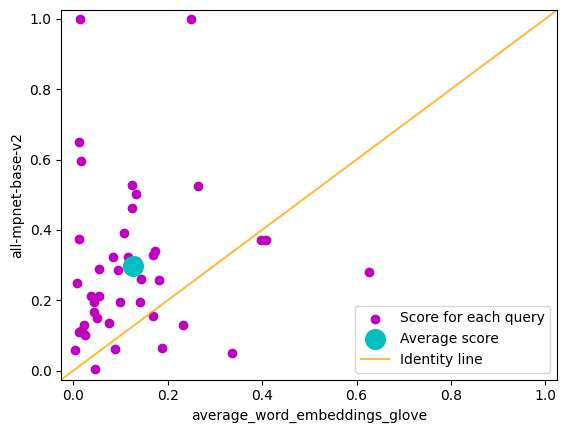

In [3]:

MODEL_SHORTCUTS = ["glove", "minil6", "minil12", "mpnetv2"]
MODEL_NAMES = ["average_word_embeddings_glove.6B.300d", "all-MiniLM-L6-v2", "all-MiniLM-L12-v2", "all-mpnet-base-v2"]

for dataset in DATASETS:
    for model_name, model_shortcut in zip(MODEL_NAMES, MODEL_SHORTCUTS):
        # indexing documents from a data set converted to embeddings into elasticsearch
        os.system(f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {model_shortcut}_{dataset} -m {model_name} -v 0")
        
        # running search on the indexed documents using queries converted to embeddings
        os.system(f"python3 embedding_search.py -q ./data/{dataset}/queries.json -i {model_shortcut}_{dataset} -m {model_name} -o ./task_02/outputs/{model_shortcut}_{dataset}.txt")
        
        # evaluating the search results with trec_eval
        os.system(f"{TREC_EVAL_COMMAND} -m map -q ./data/{dataset}/qrels-treceval.txt ./task_02/outputs/{model_shortcut}_{dataset}.txt > ./task_02/results/map_{model_shortcut}_{dataset}.txt")

# TODO add more plots with BM-25     
compare_results_scatter_plot(["./task_02/results/map_glove_cacm.txt", "./task_02/results/map_mpnetv2_cacm.txt"], ["average_word_embeddings_glove", "all-mpnet-base-v2"])

## Task 04
In this task we fine-tuned pre-trained multilingual sentence transformers and evaluated its performance on queries in different languages.

In [ ]:
# sentence transformers models
MODELS = [
    "paraphrase-multilingual-MiniLM-L12-v2", "distiluse-base-multilingual-cased-v1",
    "paraphrase-multilingual-mpnet-base-v2"
]
MODEL_SHORTCUTS = ["ml_miniLM_L12_v2", "dbmlc_v1", "ml_mpnet_base_v2"]
MODELS = ["paraphrase-multilingual-MiniLM-L12-v2"]

LANGUAGES = ["EN", "DE"]
# ? Italian and Czech
# LANGUAGES = ["EN", "DE", "IT", "CS"]

# model fine-tuning parameters
USE_EXISTING_MODEL = True   # reuse already fine-tuned models
MODEL_PATH = f"./task_04/models"
EPOCHS = 1
WARMUP_STEPS = 500
BATCH_SIZE = 16

for dataset in DATASETS:
    for model, model_shortcut in zip(MODELS, MODEL_SHORTCUTS):
        # translate queries to target language
        for language in LANGUAGES:
            os.system(
                f"python3 translate.py -l EN -s ./data/{dataset}/queries.json -t ./data/{dataset}/queries_{language}.json -d ./deepl_auth.key"
            )

        model_path = f"{MODEL_PATH}/{dataset}_{model_shortcut}/"

        # fine-tune models on the data set
        if not USE_EXISTING_MODEL:
            print(f"Fine-tuning {model} on {dataset}...")
            os.system(
                f"python3 finetune.py -m {model} -d ./data/{dataset}/{dataset}.json -f {model_path} -e {EPOCHS} -w {WARMUP_STEPS} -b {BATCH_SIZE}"
            )
        else:
            print(f"Using existing fine-tuned model {model_path} for {dataset}...")

        # convert documents to embeddings and create index in ElasticSearch
        print(f"Embedding docs and creating index for {dataset}...")
        os.system(
            f"python3 embedding_index.py -f ./data/{dataset}/{dataset}.json -i {model_shortcut.lower()}_{dataset}_fine_tuned -m {model_path} -v 0"
        )

        # search on indexed documents using queries in target languages
        for language in LANGUAGES:
            print(f"Searching for {language} queries in {dataset}...")
            os.system(
                f"python3 embedding_search.py -q ./data/{dataset}/queries_{language}.json -i {model_shortcut.lower()}_{dataset}_fine_tuned -m {model_path} -o ./task_04/outputs/{model_shortcut}_{dataset}_{language}.txt"
            )

            # evaluating the search results with trec_eval
            print(f"Evaluating {model_shortcut} on {dataset} with {language} queries...")
            os.system(
                f"trec_eval -m map -q ./data/{dataset}/qrels-treceval.txt ./task_04/outputs/{model_shortcut}_{dataset}_{language}.txt > ./task_04/results/map_{model_shortcut}_{dataset}_{language}.txt"
            )

In [ ]:
# todo
#compare_results_scatter_plot(["./task_04/results/map_glove_cacm.txt", "./task_02/results/map_mpnetv2_cacm.txt"],
#                             ["average_word_embeddings_glove", "all-mpnet-base-v2"])